# Predict if the server will be hacked.
### Data
1. Test.csv
2. Train.csv

### Expected output
Prediction of target variable "MULTIPLE_OFFENSE" which indicates the status of hack. 1 is a positive hack and 0 is a negative hack.

### Evaluation Criteria
score = recall_score(actual values, predicted values)


#### IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc, accuracy_score, confusion_matrix, recall_score
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as pltz

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [405]:
test_set = pd.read_csv("Test.csv")
train_set = pd.read_csv("Train.csv")

In [406]:
##Confirming that all our "INCIDENT_ID" values are unique in the dataset
print("Unique id in Test",len(test_set.INCIDENT_ID.unique()))
print("Unique id in Train",len(train_set.INCIDENT_ID.unique()))

Unique id in Test 15903
Unique id in Train 23856


In [407]:
print(train_set.info())
print("----------------------")
print(test_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
INCIDENT_ID         23856 non-null object
DATE                23856 non-null object
X_1                 23856 non-null int64
X_2                 23856 non-null int64
X_3                 23856 non-null int64
X_4                 23856 non-null int64
X_5                 23856 non-null int64
X_6                 23856 non-null int64
X_7                 23856 non-null int64
X_8                 23856 non-null int64
X_9                 23856 non-null int64
X_10                23856 non-null int64
X_11                23856 non-null int64
X_12                23674 non-null float64
X_13                23856 non-null int64
X_14                23856 non-null int64
X_15                23856 non-null int64
MULTIPLE_OFFENSE    23856 non-null int64
dtypes: float64(1), int64(15), object(2)
memory usage: 3.3+ MB
None
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15903 en

In [408]:
train_set.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [409]:
test_set.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64


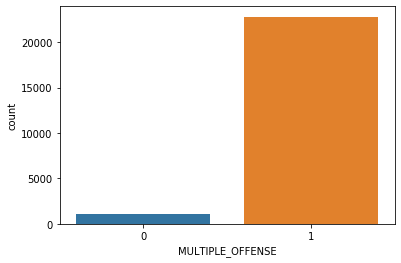

In [410]:
print(train_set["MULTIPLE_OFFENSE"].value_counts())
sns.countplot(train_set["MULTIPLE_OFFENSE"],label="Sum")

plt.show()

1. The column "X_12" has null values in both test and train dataset. I will replace the NA values using mean of the values in "X_12" column
2. The Date column will be split into 3 different columns: Month, Year and Day in order to maintain uniformity. I will drop the date column from my test and train dataset


In [411]:
##Checking for null values in train and test set
train_set.isnull().any()

INCIDENT_ID         False
DATE                False
X_1                 False
X_2                 False
X_3                 False
X_4                 False
X_5                 False
X_6                 False
X_7                 False
X_8                 False
X_9                 False
X_10                False
X_11                False
X_12                 True
X_13                False
X_14                False
X_15                False
MULTIPLE_OFFENSE    False
dtype: bool

In [412]:
 m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
train_set["YEAR"] = train_set["DATE"].map(lambda x: x.split("-")[2])
train_set["DAY"] = train_set["DATE"].map(lambda x: x.split("-")[0])
train_set["MONTH"] = train_set["DATE"].map(lambda x: m[x.split("-")[1].lower()])

test_set["YEAR"] = test_set["DATE"].map(lambda x: x.split("-")[2])
test_set["DAY"] = test_set["DATE"].map(lambda x: x.split("-")[0])
test_set["MONTH"] = test_set["DATE"].map(lambda x: m[x.split("-")[1].lower()])

val_train = [i for i in range(int(min(train_set["X_12"])),int(max(train_set["X_12"]))) if i not in train_set["X_12"].values]
train_set["X_12"].fillna(random.choice(val_train), inplace=True)

test_set["X_12"].fillna(random.choice(val_train), inplace=True)

In [413]:
train_set = train_set.drop(columns=["DATE","X_12"])
test_set = test_set.drop(columns=["DATE", "X_12"])

In [414]:
train_set.columns

Index(['INCIDENT_ID', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8',
       'X_9', 'X_10', 'X_11', 'X_13', 'X_14', 'X_15', 'MULTIPLE_OFFENSE',
       'YEAR', 'DAY', 'MONTH'],
      dtype='object')

#### Now we will split our training dataset in test and train to use it for our modeliing purpose.

In [415]:
X = train_set.drop(columns=["INCIDENT_ID","MULTIPLE_OFFENSE"],axis=1)
y = train_set["MULTIPLE_OFFENSE"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27, shuffle=True)

#### Create a log for model name and their performance

In [416]:
model_name = []
score = []
accuracy = []
f1score = []
recallscore = []
accuratly_predicted_hacks = []
accuratly_predicted_non_hacks = []

#### Models used

In [417]:
#Logistic Regression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

acc_logreg = round(logreg.score(X_train, y_train) * 100, 2)
print("Score", acc_logreg)
print('Test score: ', accuracy_score(y_test, y_pred))
print('F1_Score',f1_score(y_test,y_pred))
print('Recall Score',recall_score(y_test, y_pred))

model_name.append("Logistic Regression")
score.append(acc_logreg)
accuracy.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test,y_pred))
recallscore.append(recall_score(y_test, y_pred))

# confusion matrix
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred))
accuratly_predicted_hacks.append(con_mat[1][1])
accuratly_predicted_non_hacks.append(con_mat[0][0])
con_mat


Score 95.49
Test score:  0.9553990610328639
F1_Score 0.977139910622207
Recall Score 0.9973684210526316


,0,1
0,13,251
1,15,5685


In [418]:
#Random Forest

rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
y_pred = rfc.predict(X_test)
acc_rfc = round(rfc.score(X_train, y_train) * 100, 2)
print("Score", acc_rfc)
print("Test Score", accuracy_score(y_test, y_pred))
print('F1_Score',f1_score(y_test,rfc_pred))
print('Recall Score',recall_score(y_test, y_pred))

model_name.append("Random Forest Classification")
score.append(acc_rfc)
accuracy.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test,y_pred))
recallscore.append(recall_score(y_test, y_pred))

con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred))
accuratly_predicted_hacks.append(con_mat[1][1])
accuratly_predicted_non_hacks.append(con_mat[0][0])
con_mat

Score 99.99
Test Score 0.9936284372904092
F1_Score 0.9943057380639508
Recall Score 0.9978947368421053


,0,1
0,238,26
1,12,5688


In [419]:
# Support Vector Machines

svc = SVC(gamma="auto")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
print("Score", acc_svc)
print("Test Score", accuracy_score(y_test, y_pred))
print('F1_Score',f1_score(y_test,y_pred))
print('Recall Score',recall_score(y_test, y_pred))

model_name.append("Support Vector Machine")
score.append(acc_svc)
accuracy.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test,y_pred))
recallscore.append(recall_score(y_test, y_pred))

con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred))
accuratly_predicted_hacks.append(con_mat[1][1])
accuratly_predicted_non_hacks.append(con_mat[0][0])
con_mat

Score 99.99
Test Score 0.9564050972501676
F1_Score 0.9777015437392796
Recall Score 1.0


,0,1
0,4,260
1,0,5700


In [422]:
#KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print("Score",acc_knn)
print("Test Score", accuracy_score(y_test, y_pred))
print('F1_Score',f1_score(y_test,Y_pred))
print('Recall Score',recall_score(y_test, y_pred))
model_name.append("KNN")
score.append(acc_knn)
accuracy.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test,y_pred))
recallscore.append(recall_score(y_test, y_pred))

con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred))
accuratly_predicted_hacks.append(con_mat[1][1])
accuratly_predicted_non_hacks.append(con_mat[0][0])
con_mat

Score 97.46
Test Score 0.960261569416499
F1_Score 0.9777015437392796
Recall Score 0.9907017543859649


,0,1
0,80,184
1,53,5647


In [423]:
# Decision Tree

decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print("Score",acc_decision_tree)
print("Test Score", accuracy_score(y_test, y_pred))
print('F1_Score',f1_score(y_test,y_pred))
print('Recall Score',recall_score(y_test, y_pred))

model_name.append("Decision Tree")
score.append(acc_decision_tree)
accuracy.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test,y_pred))
recallscore.append(recall_score(y_test, y_pred))

con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred))
accuratly_predicted_hacks.append(con_mat[1][1])
accuratly_predicted_non_hacks.append(con_mat[0][0])
con_mat


Score 97.28
Test Score 0.9725016767270288
F1_Score 0.9858131487889275
Recall Score 0.9996491228070176


,0,1
0,102,162
1,2,5698


In [424]:
model_log = pd.DataFrame()
model_log["Model Name"] = model_name
model_log["Scores"] = score
model_log["Accuracy"] = accuracy
model_log["F1 score"] = f1score
model_log["Recall"] = recallscore
model_log["Accurate hacks"] = accuratly_predicted_hacks
model_log["Accurate non hacks"] = accuratly_predicted_non_hacks


In [425]:
model_log

,Model Name,Scores,Accuracy,F1 score,Recall,Accurate hacks,Accurate non hacks
0,Logistic Regression,95.49,0.955399,0.977140,0.997368,5685,13
1,Random Forest Classification,99.99,0.993628,0.996671,0.997895,5688,238
2,Support Vector Machine,99.99,0.956405,0.977702,1.000000,5700,4
3,KNN,97.46,0.960262,0.979447,0.990702,5647,80
4,Decision Tree,97.28,0.972502,0.985813,0.999649,5698,102
5,KNN,97.46,0.960262,0.979447,0.990702,5647,80
6,Decision Tree,97.28,0.972502,0.985813,0.999649,5698,102


#### On the basis of model log, Decision Tree has performed exceedingly well. The accurate hacks and accurate non hacks is satisfactory and we can see that majority of the data was correctly predicted.
#### Lets look at a few more parameters to see if its doing good

In [434]:
Sensitivity = con_mat[1][1]/(con_mat[1][1]+con_mat[1][0])
print("Sensitivity:", Sensitivity)
Specificity = con_mat[0][0]/(con_mat[0][0]+con_mat[0][1])
print("Specificity:", Specificity)

Sensitivity: 0.9723549488054608
Specificity: 0.9807692307692307


In [427]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

lr_probs = logreg.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.997


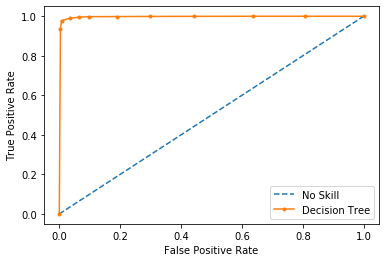

In [428]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

We will go forward with Decision Tree Classifier

In [450]:
X_train = train_set.drop(columns=["INCIDENT_ID","MULTIPLE_OFFENSE"],axis=1)
X_test = test_set.drop(columns=["INCIDENT_ID"],axis=1)
y_train = train_set["MULTIPLE_OFFENSE"]

#decision_tree = DecisionTreeClassifier()
#decision_tree.fit(X_train, y_train)

svc = SVC(gamma="auto")
svc.fit(X_train, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [452]:
#predictions = decision_tree.predict(X_test)
predictions = svc.predict(X_test)

In [453]:
submission = pd.DataFrame({'INCIDENT_ID':test_set['INCIDENT_ID'],'MULTIPLE_OFFENSE':predictions})

In [454]:
submission["MULTIPLE_OFFENSE"].value_counts()

1    15887
0       16
Name: MULTIPLE_OFFENSE, dtype: int64

In [456]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook

filename = 'predictIon_submission_SVC.csv'

submission.to_csv(filename,index=False)

We have successfully build the model and it is providing satisfactory results. 
Conclusion: Decision Tree classifier works well for the following problem statement